In [1]:
from google.colab import drive
import pandas as pd
import json
import numpy as np
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn.functional as F
from torch.utils import data
import torch.nn as nn
import torch.optim as optim

drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
df = pd.read_csv("./BTC_sum_both_30s_202303271051_v1.csv")
df.shape

(151838, 84)

In [3]:
df.columns

Index(['window_start', 'window_end', 'num_rows', 'lowest_return',
       'highest_return', 'high_low_gap', 'trade_vol', 'volume_power',
       'beginning_price', 'ending_price', 'lowest_price', 'highest_price',
       'returns', 'returns_next10m', 'realized_vol_next10m', 'time_id',
       'ob_end_ap_0', 'ob_end_as_0', 'ob_end_bp_0', 'ob_end_bs_0',
       'ob_end_ap_1', 'ob_end_as_1', 'ob_end_bp_1', 'ob_end_bs_1',
       'ob_end_ap_2', 'ob_end_as_2', 'ob_end_bp_2', 'ob_end_bs_2',
       'ob_end_ap_3', 'ob_end_as_3', 'ob_end_bp_3', 'ob_end_bs_3',
       'ob_end_ap_4', 'ob_end_as_4', 'ob_end_bp_4', 'ob_end_bs_4',
       'ob_end_ap_5', 'ob_end_as_5', 'ob_end_bp_5', 'ob_end_bs_5',
       'ob_end_ap_6', 'ob_end_as_6', 'ob_end_bp_6', 'ob_end_bs_6',
       'ob_end_ap_7', 'ob_end_as_7', 'ob_end_bp_7', 'ob_end_bs_7',
       'ob_end_ap_8', 'ob_end_as_8', 'ob_end_bp_8', 'ob_end_bs_8',
       'ob_end_ap_9', 'ob_end_as_9', 'ob_end_bp_9', 'ob_end_bs_9',
       'ob_end_ap_10', 'ob_end_as_10', 'ob_end_

# Prepeocessing

In [4]:
target = 'returns_next10m'#'realized_vol_next10m'

columns_ordered = [
    'ob_end_bp_14', 'ob_end_bs_14',
    'ob_end_bp_13', 'ob_end_bs_13',
    'ob_end_bp_12', 'ob_end_bs_12',
    'ob_end_bp_11', 'ob_end_bs_11',
    'ob_end_bp_10', 'ob_end_bs_10',
    'ob_end_bp_9', 'ob_end_bs_9',
    'ob_end_bp_8', 'ob_end_bs_8',
    'ob_end_bp_7', 'ob_end_bs_7',
    'ob_end_bp_6', 'ob_end_bs_6',
    'ob_end_bp_5', 'ob_end_bs_5',
    'ob_end_bp_4', 'ob_end_bs_4',
    'ob_end_bp_3', 'ob_end_bs_3',
    'ob_end_bp_2', 'ob_end_bs_2',
    'ob_end_bp_1', 'ob_end_bs_1',
    'ob_end_bp_0', 'ob_end_bs_0',
    'ob_end_ap_0', 'ob_end_as_0',
    'ob_end_ap_1', 'ob_end_as_1',
    'ob_end_ap_2', 'ob_end_as_2',
    'ob_end_ap_3', 'ob_end_as_3',
    'ob_end_ap_4', 'ob_end_as_4',
    'ob_end_ap_5', 'ob_end_as_5',
    'ob_end_ap_6', 'ob_end_as_6',
    'ob_end_ap_7', 'ob_end_as_7',
    'ob_end_ap_8', 'ob_end_as_8',
    'ob_end_ap_9', 'ob_end_as_9',
    'ob_end_ap_10', 'ob_end_as_10',
    'ob_end_ap_11', 'ob_end_as_11',
    'ob_end_ap_12', 'ob_end_as_12',
    'ob_end_ap_13', 'ob_end_as_13',
    'ob_end_ap_14', 'ob_end_as_14',
    'window_start',
    # 'num_rows', 'lowest_return',
    # 'highest_return', 'high_low_gap', 'trade_vol', 'volume_power',
    # 'beginning_price', 'ending_price', 'lowest_price', 'highest_price',
    # 'returns', 'ob_end_bias_0', 'ob_end_bias_1', 'ob_end_bias_4',
    # 'ob_end_bidask_spread','highest_possible_return',


    target
    ]

# DataFrame 열을 원하는 순서로 재배열
df = df.reindex(columns=columns_ordered)

In [5]:
def prepare_x(data, lv):
    lv = int(lv/2)
    # 첫 번째 범위: 30-lv부터 30+lv까지
    range1 = data.iloc[:, 30-lv : 30+lv]

    df1 = data.iloc[:, 30-lv : 30+lv]
    range2 = data.iloc[:, 61:-1]

    # 두 범위를 합쳐 새로운 df1 생성
    df1 = pd.concat([range1, range2], axis=1)
    return np.array(df1)

def get_target(data):
    return np.array(data.iloc[:, -1])

# T : look back
def data_classification(X, Y, T):
    # N : 행 개수 D : 열 개수
    [N, D] = X.shape

    df = np.array(X)
    dY = np.array(Y)

    dataY = dY[T - 1:N]
    # T-1 ~ N 사이 개수 만큼의 데이터, T,
    dataX = np.zeros((N - T + 1, T, D))

    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
        # Min-max 정규화를 위해 각 열의 최소값과 최대값 계산
        min_val = dataX[i - T].min(axis=0)
        max_val = dataX[i - T].max(axis=0)
        # 0으로 나누는 것을 방지하기 위해 조건 추가
        range_val = max_val - min_val
        range_val[range_val == 0] = 1
        # 세로 방향으로 정규화
        dataX[i - T] = (dataX[i - T] - min_val) / range_val

    return dataX, dataY

def get_index(data, start_time_str, end_time_str):
    data['window_start'] = pd.to_datetime(data['window_start'], errors='coerce')
    time = data['window_start'].dt.time

    start_time = pd.to_datetime(start_time_str).time()
    end_time = pd.to_datetime(end_time_str).time()

    return data[(time >= start_time) & (time <= end_time)].index

def expand_indices_correctly(indices, T, length):
    expanded = set(indices)  # indices 집합의 모든 요소를 먼저 expanded에 추가

    for index in indices:
        for i in range(index-T, index+T+1):  # index+T까지 포함하기 위해 +1을 함
            if 0 <= i < length:  # i가 0 이상이고 length 미만일 때만 추가
                expanded.add(i)
    return list(expanded)


def remove_data(x, y, original_data, remove_times, T):
    indices_to_remove = set()

    for start_time, end_time in remove_times :
        indices = get_index(original_data, start_time, end_time)
        print(indices)
        indices_to_remove.update(indices)

    # Calculate their expanded set
    length = original_data.shape[0] - T # x.shape[0] 같은 지 확인
    indices_to_remove = list(indices_to_remove)
    indices_to_remove = [x - T for x in indices_to_remove]
    print(indices_to_remove)
    expanded_indices = expand_indices_correctly(indices_to_remove, T, length)
    print(expanded_indices)

    # Remove the sequences that fall within these expanded indices
    x = np.delete(x, expanded_indices, axis=0)
    y = np.delete(y, expanded_indices, axis=0)

    return x, y



class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, data, T, lv, remove_times):
        """Initialization"""
        self.T = T

        x = prepare_x(data, lv)
        y = get_target(data)

        x, y = data_classification(x, y, self.T)



        # remove drawn

        if remove_times:
            x, y = remove_data(x, y, data, remove_times, self.T)
        self.length = len(x)

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, index):
        """Generates samples of data"""
        return self.x[index], self.y[index]

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

dec_train = df.iloc[:int(np.floor(df.shape[0] * 0.7))]
dec_train = dec_train.reset_index(drop=True)
dec_val = df.iloc[int(np.floor(df.shape[0] * 0.7)):int(np.floor(df.shape[0] * 0.85))]
dec_val = dec_val.reset_index(drop=True)
dec_test = df.iloc[int(np.floor(df.shape[0] * 0.85)): ]
dec_test = dec_test.reset_index(drop=True)
# dec_train, dec_val, dec_test의 마지막 열을 제외한 부분과 마지막 열을 분리합니다.
# dec_train_features = dec_train.iloc[:, :-1]
# dec_train_labels = dec_train.iloc[:, -1]

# dec_val_features = dec_val.iloc[:, :-1]
# dec_val_labels = dec_val.iloc[:, -1]

# dec_test_features = dec_test.iloc[:, :-1]
# dec_test_labels = dec_test.iloc[:, -1]

# # dec_train_features에서 각 열의 평균과 표준편차를 계산합니다.
# train_mean = dec_train_features.mean()
# train_std = dec_train_features.std()

# val_mean = dec_train_features.mean()
# val_std = dec_train_features.std()

# test_mean = dec_train_features.mean()
# test_std = dec_train_features.std()

# # 표준화: (X - mean) / std, 마지막 열은 제외하고 표준화합니다.
# dec_train_features = (dec_train_features - train_mean) / train_std
# dec_val_features = (dec_val_features - val_mean) / val_std
# dec_test_features = (dec_test_features - test_mean) / test_std

# # 표준화된 데이터와 마지막 열을 다시 결합합니다.
# dec_train = pd.concat([dec_train_features, dec_train_labels], axis=1)
# dec_val = pd.concat([dec_val_features, dec_val_labels], axis=1)
# dec_test = pd.concat([dec_test_features, dec_test_labels], axis=1)

print(dec_train.shape, dec_val.shape, dec_test.shape)

del df

(106286, 62) (22776, 62) (22776, 62)


In [7]:
batch_size = 64
LV = 28# [16, 20, 28, 36, 44, 52, 60]
T = 240 # 120, 240, 360 , 480, 600, 720
m = 'd' # deeplob : d , Lobster : g , LobTrans : t
remove_times = [('00:00:00', '06:20:00'), ('23:45:00', '23:59:59')]

dataset_train = Dataset(data=dec_train, T=T, lv=LV, remove_times=remove_times)
dataset_val = Dataset(data=dec_val, T=T, lv=LV, remove_times=remove_times)
dataset_test = Dataset(data=dec_test, T=T, lv=LV, remove_times=remove_times)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

print(dataset_train.x.shape, dataset_train.y.shape)

del dataset_val, dataset_test

Int64Index([   328,    329,    330,    331,    332,    333,    334,    335,
               336,    337,
            ...
            104839, 104840, 104841, 104842, 104843, 104844, 104845, 104846,
            104847, 104848],
           dtype='int64', length=1940)
Int64Index([   319,    320,    321,    322,    323,    324,    325,    326,
               327,   2455,
            ...
            102670, 104800, 104801, 104802, 104803, 104804, 104805, 104806,
            104807, 104808],
           dtype='int64', length=450)
[48987, 48988, 48989, 48990, 48991, 48992, 48993, 48994, 48995, 48996, 48997, 48998, 48999, 49000, 49001, 49002, 49003, 49004, 49005, 49006, 49007, 49008, 49009, 49010, 49011, 49012, 49013, 49014, 49015, 49016, 49017, 49018, 49019, 49020, 49021, 49022, 49023, 49024, 49025, 49026, 49027, 49028, 49029, 49030, 49031, 49032, 49033, 49034, 98178, 98179, 98180, 98181, 98182, 98183, 98184, 98185, 98186, 98187, 98188, 98189, 98190, 98191, 98192, 98193, 98194, 79, 80, 81, 82, 8

### LSTM

In [8]:
# @title
import torch
import torch.nn as nn

class Deeplob(nn.Module):
    def __init__(self, level):
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.name = 'Deeplob'

        # convolution blocks
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1, 2), stride=(1, 2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 2), stride=(1, 2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        conv3_kernel_size = int(level/4)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, conv3_kernel_size)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # inception modules
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )

        # gru layers
        self.dropout = nn.Dropout(p=0.1)
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        # 변경된 부분: 최종 출력을 1로 설정하여 회귀 문제에 맞게 조정
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 64).to(self.device)
        c0 = torch.zeros(1, x.size(0), 64).to(self.device)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)

        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)
        # 차원 위치 변환
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        x = self.dropout(x)
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]

        # 변경된 부분: softmax 제거 및 직접 회귀 값을 출력
        x = self.fc1(x)
        return x


### GRU

In [9]:
# @title
import torch
import torch.nn as nn

class Lobster(nn.Module):
    def __init__(self, level):
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.name = 'lobster'

        # convolution blocks
        self.conv1 = nn.Sequential(
            # in_channels = 이미지 한 장 (가로 축 : bid 16 ~ ask 16 / 세로 축 : Look Back 행 수)
            # (1,2) size 32개 Filter로 (1,2) stride => 가격+잔량 데이터 압축 (압축 호가)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1, 2), stride=(1, 2)),
            # x<0 구간은 y=0.01x ReLU
            nn.LeakyReLU(negative_slope=0.01),
            # 32개의 out_channels 배치 정규화
            nn.BatchNorm2d(32),

            # Lookback (세로 방향) 으로 4행만큼 정보 압축 => 세로 방향 shape 3 감소
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # Lookback (세로 방향) 으로 4행만큼 정보 압축 => 세로 방향 shape 3 감소
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        self.conv2 = nn.Sequential(
            # 압축 호가 2호가에 대해서 추가 압축호가 분석
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 2), stride=(1, 2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # Lookback (세로 방향) 으로 4행만큼 정보 압축 => 세로 방향 shape 3 감소
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # Lookback (세로 방향) 으로 4행만큼 정보 압축 => 세로 방향 shape 3 감소
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # 전체 압축 호가를 1개의 Feature로 압축
        # 압축호가 걸침에 따라 호가 Feature는 (가로) 1/4로 압축이 됨
        # Output Shape 4차원 : batchsize, channels, lookback -18, 압축호가 1
        conv3_kernel_size = int(level/4)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, conv3_kernel_size)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # inception modules
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )

        # gru layers
        self.dropout = nn.Dropout(p=0.1)
        self.gru = nn.GRU(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        # 변경된 부분: 최종 출력을 1로 설정하여 회귀 문제에 맞게 조정
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 64).to(self.device)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)

        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)

        # 0 : batch size, 1 : sum of out_channels, 2: Look Back 3 : 압축 호가
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        x = self.dropout(x)
        x, _ = self.gru(x, h0)
        x = x[:, -1, :]

        x = self.fc1(x)
        return x


### Transformer

In [10]:
# @title
import torch
import torch.nn as nn
import torch.nn.functional as F

class LobTrans(nn.Module):
    def __init__(self, level):
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.name = 'lobster'

        # convolution blocks

        self.conv1 = nn.Sequential(

            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1, 2), stride=(1, 2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 2), stride=(1, 2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        conv3_kernel_size = int(level/4)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, conv3_kernel_size)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # inception modules
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )

        self.dropout = nn.Dropout(p=0.1)

        # Transformer layers
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=192, # 이전 GRU의 input_size와 동일해야 합니다.
            nhead=6,     # 멀티 헤드 어텐션의 헤드 수
            dim_feedforward=512, # 피드포워드 네트워크의 차원
            dropout=0.1
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, num_layers=1) # 레이어 수 조정 가능

        # 변경된 부분: 최종 출력을 1로 설정하여 회귀 문제에 맞게 조정
        self.fc1 = nn.Linear(192, 1) # d_model에 따라 조정

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x_inp1 = self.inp1(x)
        x_inp2 = self.inp2(x)
        x_inp3 = self.inp3(x)

        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)

        x = x.permute(0, 2, 3, 1) # NxCxHxW -> NxHxWxC
        x = torch.reshape(x, (-1, x.shape[1], x.shape[3])) # NxHx(C*W)
        x = self.dropout(x)

        x = self.transformer_encoder(x)
        x = x[:, -1, :] # 마지막 시퀀스의 출력 사용

        x = self.fc1(x)
        return x


# ADD Feature with CNN

In [11]:
# @title
import torch
import torch.nn as nn

class Lobster_A(nn.Module):
    def __init__(self, level):
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.name = 'lobster'

        # convolution blocks
        self.conv1 = nn.Sequential(
            # in_channels = 이미지 한 장 (가로 축 : bid 16 ~ ask 16 / 세로 축 : Look Back 행 수)
            # (1,2) size 32개 Filter로 (1,2) stride => 가격+잔량 데이터 압축 (압축 호가)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1, 2), stride=(1, 2)),
            # x<0 구간은 y=0.01x ReLU
            nn.LeakyReLU(negative_slope=0.01),
            # 32개의 out_channels 배치 정규화
            nn.BatchNorm2d(32),

            # Lookback (세로 방향) 으로 4행만큼 정보 압축 => 세로 방향 shape 3 감소
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # Lookback (세로 방향) 으로 4행만큼 정보 압축 => 세로 방향 shape 3 감소
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        self.conv2 = nn.Sequential(
            # 압축 호가 2호가에 대해서 추가 압축호가 분석
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 2), stride=(1, 2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # Lookback (세로 방향) 으로 4행만큼 정보 압축 => 세로 방향 shape 3 감소
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # Lookback (세로 방향) 으로 4행만큼 정보 압축 => 세로 방향 shape 3 감소
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # 전체 압축 호가를 1개의 Feature로 압축
        # 압축호가 걸침에 따라 호가 Feature는 (가로) 1/4로 압축이 됨
        # Output Shape 4차원 : batchsize, channels, lookback -18, 압축호가 1
        conv3_kernel_size = int(level/4)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, conv3_kernel_size)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # 추가 Feature CNN 분석
        features = 16
        self.conv1_1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1, features)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(10, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(10, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # inception modules
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
		# 추가 Feature Inception 분석
        self.inp1_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )

        self.inp2_1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3_1 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )


        # gru layers
        self.dropout = nn.Dropout(p=0.1)
        self.lstm = nn.LSTM(input_size=384, hidden_size=64, num_layers=1, batch_first=True)
        # 변경된 부분: 최종 출력을 1로 설정하여 회귀 문제에 맞게 조정
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 64).to(self.device)
        c0 = torch.zeros(1, x.size(0), 64).to(self.device)

        # 첫 번째 부분: 마지막 차원에서 처음 28개 요소 선택
        x_part1 = x[:, :, :, :28]

        # 두 번째 부분: 마지막 차원에서 나머지 19개 요소 선택
        x_part2 = x[:, :, :, 28:]

        x_part1 = self.conv1(x_part1)
        x_part1 = self.conv2(x_part1)
        x_part1 = self.conv3(x_part1)

        x_part2 = self.conv1_1(x_part2)

        x_inp1 = self.inp1(x_part1)
        x_inp2 = self.inp2(x_part1)
        x_inp3 = self.inp3(x_part1)

        x_inp1_1 = self.inp1_1(x_part2)
        x_inp2_1 = self.inp2_1(x_part2)
        x_inp3_1 = self.inp3_1(x_part2)
        #print(x_inp1.shape, x_inp1_1.shape)
        x = torch.cat((x_inp1, x_inp2, x_inp3, x_inp1_1, x_inp2_1, x_inp3_1), dim=1)

        # 0 : batch size, 1 : sum of out_channels, 2: Look Back 3 : 압축 호가
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        x = self.dropout(x)
        x, _ = self.lstm(x, (h0, c0))
        x = x[:, -1, :]

        x = self.fc1(x)
        return x

# ADD Feature with LSTM LSTM

In [12]:
import torch
import torch.nn as nn

class Lobster_A(nn.Module):
    def __init__(self, level):
        super().__init__()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.name = 'lobster'

        # convolution blocks
        self.conv1 = nn.Sequential(
            # in_channels = 이미지 한 장 (가로 축 : bid 16 ~ ask 16 / 세로 축 : Look Back 행 수)
            # (1,2) size 32개 Filter로 (1,2) stride => 가격+잔량 데이터 압축 (압축 호가)
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1, 2), stride=(1, 2)),
            # x<0 구간은 y=0.01x ReLU
            nn.LeakyReLU(negative_slope=0.01),
            # 32개의 out_channels 배치 정규화
            nn.BatchNorm2d(32),

            # Lookback (세로 방향) 으로 4행만큼 정보 압축 => 세로 방향 shape 3 감소
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # Lookback (세로 방향) 으로 4행만큼 정보 압축 => 세로 방향 shape 3 감소
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        self.conv2 = nn.Sequential(
            # 압축 호가 2호가에 대해서 추가 압축호가 분석
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 2), stride=(1, 2)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # Lookback (세로 방향) 으로 4행만큼 정보 압축 => 세로 방향 shape 3 감소
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # Lookback (세로 방향) 으로 4행만큼 정보 압축 => 세로 방향 shape 3 감소
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # 전체 압축 호가를 1개의 Feature로 압축
        # 압축호가 걸침에 따라 호가 Feature는 (가로) 1/4로 압축이 됨
        # Output Shape 4차원 : batchsize, channels, lookback -18, 압축호가 1
        conv3_kernel_size = int(level/4)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, conv3_kernel_size)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(4, 1)),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),
        )

        # inception modules
        self.inp1 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        self.inp3 = nn.Sequential(
            nn.MaxPool2d((3, 1), stride=(1, 1), padding=(1, 0)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), padding='same'),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(64),
        )
        # LSTM 모델 생성
        self.flstm = nn.LSTM(input_size=16, hidden_size=192, num_layers=1, batch_first=True)

        # gru layers
        self.dropout = nn.Dropout(p=0.1)
        self.lstm = nn.LSTM(input_size=192, hidden_size=64, num_layers=1, batch_first=True)
        # 변경된 부분: 최종 출력을 1로 설정하여 회귀 문제에 맞게 조정
        self.fc1 = nn.Linear(128, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), 64).to(self.device)
        c0 = torch.zeros(1, x.size(0), 64).to(self.device)

        h1 = torch.zeros(1, x.size(0), 192).to(self.device)
        c1 = torch.zeros(1, x.size(0), 192).to(self.device)

        # 첫 번째 부분: 마지막 차원에서 처음 28개 요소 선택
        x_part1 = x[:, :, :, :28]

        # 두 번째 부분: 마지막 차원에서 나머지 19개 요소 선택
        x_part2 = x[:, :, :, 28:]
        x_part2 = x_part2.squeeze(1)  # 두 번째 차원 제거

        x_part1 = self.conv1(x_part1)
        x_part1 = self.conv2(x_part1)
        x_part1 = self.conv3(x_part1)

        x_inp1 = self.inp1(x_part1)
        x_inp2 = self.inp2(x_part1)
        x_inp3 = self.inp3(x_part1)

        x_l, _ = self.flstm(x_part2, (h1, c1))
        x_l = x_l[:, -1, -64:]
        #print(x_l.shape) # torch.Size([64, 600, 192])

        x = torch.cat((x_inp1, x_inp2, x_inp3), dim=1)

        # 0 : batch size, 1 : sum of out_channels, 2: Look Back 3 : 압축 호가
        x = x.permute(0, 2, 1, 3)
        x = torch.reshape(x, (-1, x.shape[1], x.shape[2]))
        x = self.dropout(x)
        x, _ = self.lstm(x, (h0, c0))

        #print(x.shape) # torch.Size([64, 582, 64]
        x = x[:, -1, :]
        #print(x.shape) # torch.Size([64, 64])
        x = torch.cat((x, x_l), dim=1)
        x = self.fc1(x)
        return x

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Case 구문을 사용하여 m 값에 따라 모델 변수 설정
model = None
match m:
    case 'd':
        model = Deeplob(level=LV)
    case 'g':
        model = Lobster_A(level=LV)
    case 't':
        model = LobTrans(level=LV)
    case _:
        raise ValueError(f"알 수 없는 모델 종류: {m}")


model.to(device)

Deeplob(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (7): LeakyReLU(negative_slope=0.01)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(1, 2), stride=(1, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(4, 1), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [14]:
# from torchinfo import summary
#pip install torchinfo
# 1383435, 1, 1200, 28
# summary(model, (64, 1, 600, 44))

In [15]:
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm
from datetime import datetime

# Update the loss function to MSELoss for regression
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = []
    test_losses = []
    best_test_loss = np.inf

    for it in tqdm(range(epochs)):
        model.train()
        t0 = datetime.now()
        train_loss = []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.float()  # inputs를 float 타입으로 변환
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.float().unsqueeze(1))  # Ensure targets are the correct shape for regression
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())

        train_loss = np.mean(train_loss)

        model.eval()
        test_loss = []

        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.float()  # inputs를 float 타입으로 변환
            outputs = model(inputs)
            loss = criterion(outputs, targets.float().unsqueeze(1))
            test_loss.append(loss.item())

        test_loss = np.mean(test_loss)

        if test_loss < best_test_loss:
            torch.save(model.state_dict(), './drive/MyDrive/models/lv{}_t{}_{}.pt'.format(LV, T, m))
            best_test_loss = test_loss

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {test_loss}, Duration: {dt}')
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    return train_losses, test_losses

train_losses, val_losses = batch_gd(model, criterion, optimizer,
                                    train_loader, val_loader, epochs=40)

  2%|▎         | 1/40 [01:29<58:27, 89.94s/it]

Epoch 1/40, Train Loss: 0.0037122578083560653, Val Loss: 0.0009975932371440051, Duration: 0:01:29.940059


  5%|▌         | 2/40 [02:57<56:07, 88.61s/it]

Epoch 2/40, Train Loss: 0.0007661773728241081, Val Loss: 0.00029079445454141816, Duration: 0:01:27.679473


  8%|▊         | 3/40 [04:25<54:23, 88.21s/it]

Epoch 3/40, Train Loss: 0.00026219081758846675, Val Loss: 9.642195776946938e-05, Duration: 0:01:27.738187


 10%|█         | 4/40 [05:53<52:48, 88.01s/it]

Epoch 4/40, Train Loss: 0.00010080006553636896, Val Loss: 3.5521239926366495e-05, Duration: 0:01:27.689049


 12%|█▎        | 5/40 [07:20<51:14, 87.85s/it]

Epoch 5/40, Train Loss: 4.3698674722656084e-05, Val Loss: 1.4139343906527889e-05, Duration: 0:01:27.576761


 15%|█▌        | 6/40 [08:48<49:45, 87.80s/it]

Epoch 6/40, Train Loss: 2.0529066495975294e-05, Val Loss: 6.805343660025686e-06, Duration: 0:01:27.709120


 18%|█▊        | 7/40 [10:16<48:16, 87.78s/it]

Epoch 7/40, Train Loss: 1.0880847568728313e-05, Val Loss: 3.9093861178446415e-06, Duration: 0:01:27.714789


 20%|██        | 8/40 [11:43<46:49, 87.80s/it]

Epoch 8/40, Train Loss: 6.455473734508115e-06, Val Loss: 2.8050689163748535e-06, Duration: 0:01:27.856846


 22%|██▎       | 9/40 [13:11<45:21, 87.79s/it]

Epoch 9/40, Train Loss: 4.461469930998436e-06, Val Loss: 2.448937707821163e-06, Duration: 0:01:27.765337


 25%|██▌       | 10/40 [14:39<43:53, 87.80s/it]

Epoch 10/40, Train Loss: 3.470088056445046e-06, Val Loss: 2.1691233948152727e-06, Duration: 0:01:27.811693


 28%|██▊       | 11/40 [16:07<42:25, 87.76s/it]

Epoch 11/40, Train Loss: 2.960607559634226e-06, Val Loss: 2.0572478837548365e-06, Duration: 0:01:27.677068


 30%|███       | 12/40 [17:34<40:56, 87.75s/it]

Epoch 12/40, Train Loss: 2.7011001711558106e-06, Val Loss: 1.9258092625057695e-06, Duration: 0:01:27.706146


 32%|███▎      | 13/40 [19:02<39:29, 87.75s/it]

Epoch 13/40, Train Loss: 2.5694253485434106e-06, Val Loss: 1.8715713356774352e-06, Duration: 0:01:27.750309


 35%|███▌      | 14/40 [20:30<38:01, 87.75s/it]

Epoch 14/40, Train Loss: 2.4702467555470503e-06, Val Loss: 1.913845992775531e-06, Duration: 0:01:27.749941


 38%|███▊      | 15/40 [21:58<36:33, 87.75s/it]

Epoch 15/40, Train Loss: 2.4367210185570725e-06, Val Loss: 1.8570441354848538e-06, Duration: 0:01:27.746882


 40%|████      | 16/40 [23:25<35:05, 87.73s/it]

Epoch 16/40, Train Loss: 2.3852130306195454e-06, Val Loss: 1.8689881876647257e-06, Duration: 0:01:27.694561


 42%|████▎     | 17/40 [24:53<33:38, 87.75s/it]

Epoch 17/40, Train Loss: 2.352441003886168e-06, Val Loss: 2.0650601822948904e-06, Duration: 0:01:27.778562


 45%|████▌     | 18/40 [26:21<32:10, 87.76s/it]

Epoch 18/40, Train Loss: 2.3245999019722444e-06, Val Loss: 1.943519885729895e-06, Duration: 0:01:27.773876


 48%|████▊     | 19/40 [27:49<30:42, 87.74s/it]

Epoch 19/40, Train Loss: 2.232186273541623e-06, Val Loss: 1.980175698906892e-06, Duration: 0:01:27.688829


 50%|█████     | 20/40 [29:16<29:14, 87.72s/it]

Epoch 20/40, Train Loss: 2.160279919895294e-06, Val Loss: 1.980370804884068e-06, Duration: 0:01:27.679981


 52%|█████▎    | 21/40 [30:44<27:46, 87.72s/it]

Epoch 21/40, Train Loss: 1.960922835026625e-06, Val Loss: 2.0317997893817596e-06, Duration: 0:01:27.729000


 55%|█████▌    | 22/40 [32:12<26:18, 87.72s/it]

Epoch 22/40, Train Loss: 1.7878173215134204e-06, Val Loss: 2.083040274376761e-06, Duration: 0:01:27.709227


 57%|█████▊    | 23/40 [33:39<24:51, 87.71s/it]

Epoch 23/40, Train Loss: 1.6490901105752753e-06, Val Loss: 2.2020741498015695e-06, Duration: 0:01:27.700426


 60%|██████    | 24/40 [35:07<23:22, 87.66s/it]

Epoch 24/40, Train Loss: 1.5224511814200998e-06, Val Loss: 2.5819673130661765e-06, Duration: 0:01:27.534166


 62%|██████▎   | 25/40 [36:35<21:55, 87.67s/it]

Epoch 25/40, Train Loss: 1.39597394831179e-06, Val Loss: 2.2457589026616187e-06, Duration: 0:01:27.696249


 65%|██████▌   | 26/40 [38:02<20:27, 87.68s/it]

Epoch 26/40, Train Loss: 1.2904490594277645e-06, Val Loss: 2.2051985450648596e-06, Duration: 0:01:27.708114


 68%|██████▊   | 27/40 [39:30<18:59, 87.65s/it]

Epoch 27/40, Train Loss: 1.1843149624068105e-06, Val Loss: 2.337420200355266e-06, Duration: 0:01:27.567880


 70%|███████   | 28/40 [40:57<17:30, 87.56s/it]

Epoch 28/40, Train Loss: 1.0952438295328775e-06, Val Loss: 2.435958328458527e-06, Duration: 0:01:27.356890


 72%|███████▎  | 29/40 [42:25<16:02, 87.53s/it]

Epoch 29/40, Train Loss: 1.0197264821261324e-06, Val Loss: 2.494112048655809e-06, Duration: 0:01:27.442944


 75%|███████▌  | 30/40 [43:52<14:35, 87.52s/it]

Epoch 30/40, Train Loss: 9.480152227453322e-07, Val Loss: 2.340523833451337e-06, Duration: 0:01:27.510736


 78%|███████▊  | 31/40 [45:20<13:08, 87.59s/it]

Epoch 31/40, Train Loss: 8.830834864271289e-07, Val Loss: 2.339304612628647e-06, Duration: 0:01:27.745487


 80%|████████  | 32/40 [46:48<11:41, 87.64s/it]

Epoch 32/40, Train Loss: 8.242920206004173e-07, Val Loss: 2.412811059332485e-06, Duration: 0:01:27.759096


 82%|████████▎ | 33/40 [48:15<10:13, 87.64s/it]

Epoch 33/40, Train Loss: 7.658394612947862e-07, Val Loss: 2.3854962617704376e-06, Duration: 0:01:27.632561


 85%|████████▌ | 34/40 [49:43<08:45, 87.63s/it]

Epoch 34/40, Train Loss: 7.195778035309694e-07, Val Loss: 2.4154875391946526e-06, Duration: 0:01:27.600882


 88%|████████▊ | 35/40 [51:11<07:18, 87.62s/it]

Epoch 35/40, Train Loss: 6.827224618123095e-07, Val Loss: 2.412746045160322e-06, Duration: 0:01:27.609935


 90%|█████████ | 36/40 [52:38<05:50, 87.61s/it]

Epoch 36/40, Train Loss: 6.457479801706511e-07, Val Loss: 2.4228932113753205e-06, Duration: 0:01:27.583228


 92%|█████████▎| 37/40 [54:06<04:22, 87.64s/it]

Epoch 37/40, Train Loss: 6.174346279381054e-07, Val Loss: 2.491372573484926e-06, Duration: 0:01:27.705336


 95%|█████████▌| 38/40 [55:34<02:55, 87.69s/it]

Epoch 38/40, Train Loss: 5.921169701558973e-07, Val Loss: 2.525084733754405e-06, Duration: 0:01:27.804671


 98%|█████████▊| 39/40 [57:01<01:27, 87.68s/it]

Epoch 39/40, Train Loss: 5.640357905178917e-07, Val Loss: 2.4730108264985983e-06, Duration: 0:01:27.662008


100%|██████████| 40/40 [58:29<00:00, 87.74s/it]

Epoch 40/40, Train Loss: 5.340439090836742e-07, Val Loss: 2.434144541095645e-06, Duration: 0:01:27.683557


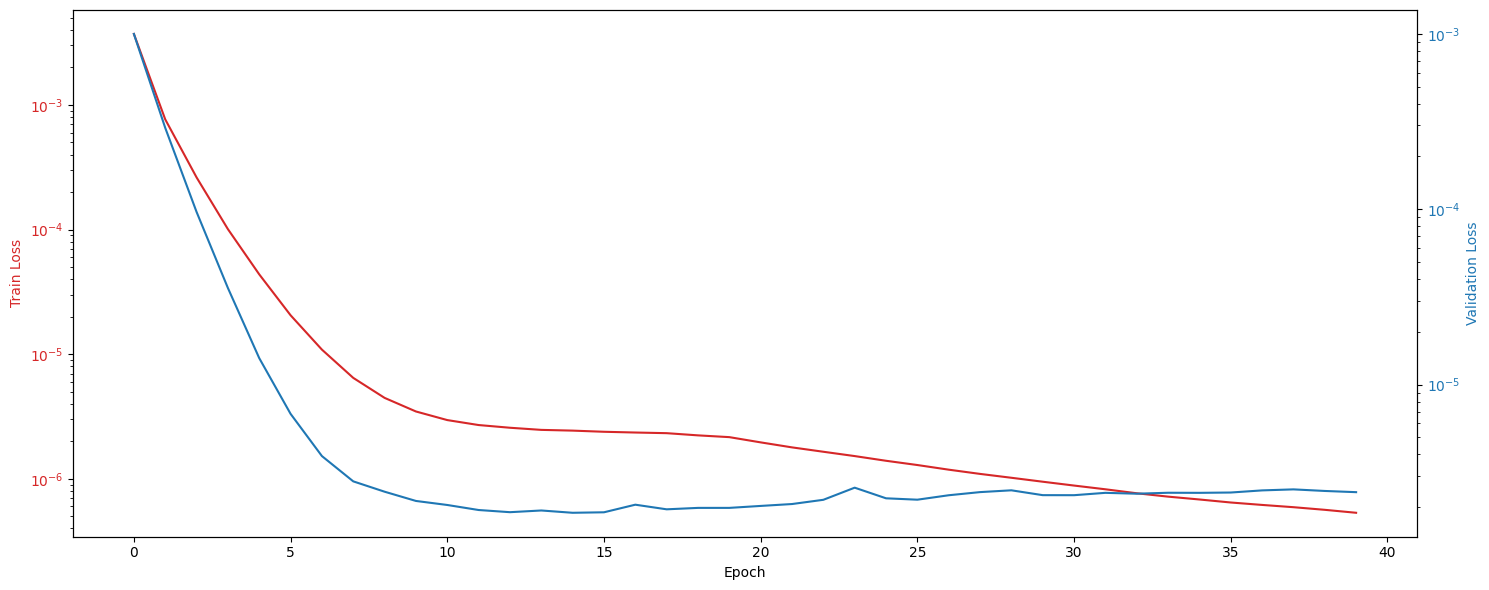

In [16]:
fig, ax1 = plt.subplots(figsize=(15,6))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color=color)
ax1.plot(train_losses, color=color, label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')  # 로그 스케일 적용

ax2 = ax1.twinx() # 동일한 x축을 공유하는 두 번째 y축을 생성
color = 'tab:blue'
ax2.set_ylabel('Validation Loss', color=color)
ax2.plot(val_losses, color=color, label='Validation Loss')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')  # 로그 스케일 적용

fig.tight_layout() # 오른쪽 y축 라벨이 잘리지 않도록 조정
plt.show()


In [17]:
from sklearn.metrics import confusion_matrix

# model = torch.load('./drive/MyDrive/models/lv{}_t{}_{}.pt'.format(28, 240, d))
# 모델을 평가 모드로 설정
model.eval()

# 예측과 정답을 저장할 리스트 초기화
all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:
        # GPU로 데이터 이동
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.float)

        # Forward pass
        outputs = model(inputs)

        # 결과 저장
        all_predictions.extend(outputs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# 넘파이 배열로 변환
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)



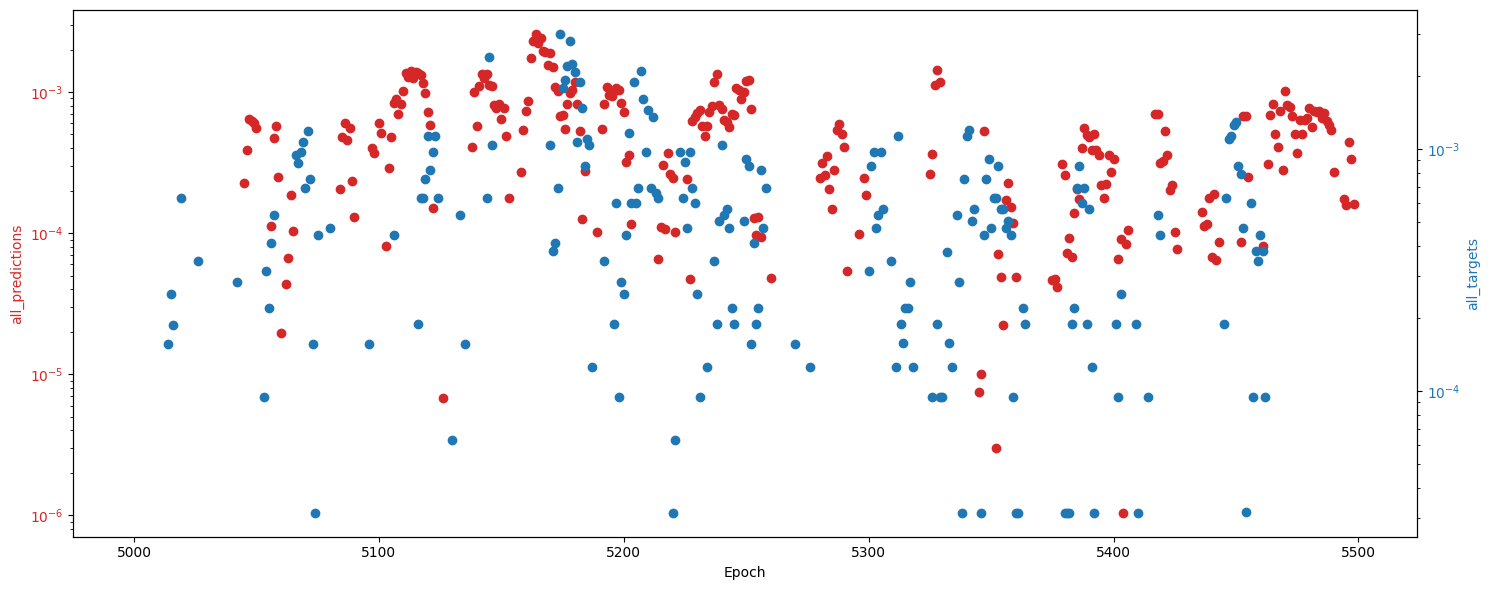

In [18]:
fig, ax1 = plt.subplots(figsize=(15, 6))

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('all_predictions', color=color)
ax1.scatter(range(5000, 5500), all_predictions[8000:8500], color=color, label='Train Loss')  # 산점도로 변경
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale('log')  # 로그 스케일 적용

ax2 = ax1.twinx()  # 동일한 x축을 공유하는 두 번째 y축을 생성
color = 'tab:blue'
ax2.set_ylabel('all_targets', color=color)
ax2.scatter(range(5000, 5500), all_targets[5000:5500], color=color, label='Validation Loss')  # 산점도로 변경
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')  # 로그 스케일 적용

fig.tight_layout()  # 오른쪽 y축 라벨이 잘리지 않도록 조정
plt.show()

In [19]:
import numpy as np

def calculate_metrics(y_true, y_pred):
    """
    계산된 RMSPE, R-squared, MAE 값을 반환합니다.

    매개변수:
    - y_true: 실제 값이 담긴 NumPy 배열
    - y_pred: 예측 값이 담긴 NumPy 배열

    반환값:
    - rmspe: 계산된 RMSPE 값
    - r_squared: 계산된 R-squared 값
    - mae: 계산된 MAE 값
    """
    # 0으로 나누는 것을 방지하기 위해, 실제 값이 0인 경우를 처리
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)  # 실제 값이 0인 경우 eps로 대체
    rmspe = np.sqrt(np.mean(((y_true - y_pred) / y_true) ** 2))

    # R-squared 계산
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # MAE 계산
    mae = np.mean(np.abs(y_true - y_pred))

    return rmspe, r_squared, mae

# 함수 사용 예시
rmspe, r_squared, mae = calculate_metrics(all_targets, all_predictions)
print("RMSPE:", rmspe)
print("R-squared:", r_squared)
print("MAE:", mae)


RMSPE: 432568400000.0
R-squared: -20635.046875
MAE: 0.0013987311


In [20]:
LV, T, m

(28, 240, 'd')